In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import json
import os
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    
    for root, _, files in os.walk(DIR):
        for file in files:
            if file.endswith('.png'):
#     for IMAGE_NAME in tqdm(os.listdir(DIR)):
                PATH = os.path.join(root,file)
                
    
#         _, ftype = os.path.splitext(PATH)
#         if ftype == ".png":
                img = read(PATH)

                img = cv2.resize(img, (RESIZE,RESIZE))
#                 if len(IMG) == 1000:
#                     return IMG

                IMG.append(np.array(img))
    return IMG

benign_A_train = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/A/data/Train/Benign',124))
malign_A_train = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/A/data/Train/Malignant',124))
benign_A_test = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/A/data/Test/Benign',124))
malign_A_test = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/A/data/Test/Malignant',124))
benign_B = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/B/BreaKHis_Total_dataset/benign',124))
malign_B = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/B/BreaKHis_Total_dataset/malignant',124))
benign_C = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/C/Dataset_BUSI_with_GT/benign',124))
malign_C = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/C/Dataset_BUSI_with_GT/malignant',124))
Normal_C = np.array(Dataset_loader('/content/gdrive/MyDrive/Datasets/C/Dataset_BUSI_with_GT/normal',124))

In [4]:
benign_train = np.concatenate((benign_A_train, benign_B, benign_C ), axis=0)
benign_test = benign_A_test
malign_train = np.concatenate((malign_A_train, malign_B, malign_C ), axis=0)
malign_test = malign_A_test



# Create Label

In [5]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
normal_label = np.full(len(Normal_C), 2)

# Merge data 
X_train = np.concatenate((benign_train, malign_train, Normal_C), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label, normal_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

# Train and Evalutation split

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

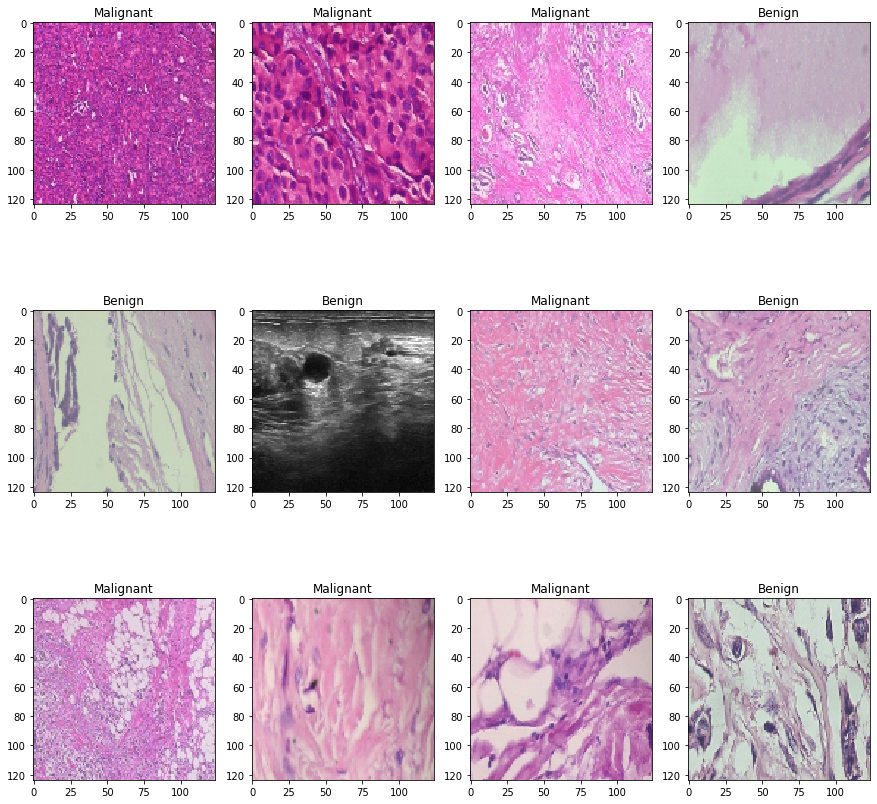

In [7]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
      ax.title.set_text('Benign')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Malignant')
    else:
        ax.title.set_text('Normal')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [8]:
# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: DenseNet

In [11]:
from keras import layers
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(3, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [12]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(124,124,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3)                 5763      
                                                                 
Total params: 18,335,427
Trainable params: 18,102,531
No

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [14]:
history = model.fit(
    x_train, y_train, 
    batch_size=30,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/10
272/272 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.8245


Epoch 1: val_accuracy improved from -inf to 0.91262, saving model to weights.best.hdf5
272/272 [==============================] - 93s 223ms/step - loss: 0.4989 - accuracy: 0.8245 - val_loss: 0.2404 - val_accuracy: 0.9126 - lr: 1.0000e-04
Epoch 2/10
272/272 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9438


Epoch 2: val_accuracy improved from 0.91262 to 0.94011, saving model to weights.best.hdf5
272/272 [==============================] - 53s 194ms/step - loss: 0.1640 - accuracy: 0.9438 - val_loss: 0.1849 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 3/10
272/272 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9655


Epoch 3: val_accuracy improved from 0.94011 to 0.94551, saving model to weights.best.hdf5
272/272 [==============================] - 53s 195ms/step - loss: 0.1028 - accuracy: 0.9655 - val_loss: 0.2089 - val_accuracy: 0.9455 - lr: 1.0000e-04
Epoch 4/10
272/272 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9812


Epoch 4: val_accuracy did not improve from 0.94551
272/272 [==============================] - 53s 195ms/step - loss: 0.0586 - accuracy: 0.9812 - val_loss: 0.2010 - val_accuracy: 0.9411 - lr: 1.0000e-04
Epoch 5/10
272/272 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9850


Epoch 5: val_accuracy improved from 0.94551 to 0.94747, saving model to weights.best.hdf5
272/272 [==============================] - 53s 196ms/step - loss: 0.0468 - accuracy: 0.9850 - val_loss: 0.1918 - val_accuracy: 0.9475 - lr: 1.0000e-04
Epoch 6/10
272/272 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9858


Epoch 6: val_accuracy improved from 0.94747 to 0.95042, saving model to weights.best.hdf5
272/272 [==============================] - 55s 204ms/step - loss: 0.0447 - accuracy: 0.9858 - val_loss: 0.1796 - val_accuracy: 0.9504 - lr: 1.0000e-04
Epoch 7/10
272/272 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9838


Epoch 7: val_accuracy did not improve from 0.95042
272/272 [==============================] - 53s 195ms/step - loss: 0.0489 - accuracy: 0.9838 - val_loss: 0.2478 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 8/10
272/272 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9860


Epoch 8: val_accuracy did not improve from 0.95042
272/272 [==============================] - 53s 194ms/step - loss: 0.0425 - accuracy: 0.9860 - val_loss: 0.2837 - val_accuracy: 0.9239 - lr: 1.0000e-04
Epoch 9/10
272/272 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9920


Epoch 9: val_accuracy improved from 0.95042 to 0.96220, saving model to weights.best.hdf5
272/272 [==============================] - 53s 195ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.1634 - val_accuracy: 0.9622 - lr: 1.0000e-04
Epoch 10/10
272/272 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9929


Epoch 10: val_accuracy did not improve from 0.96220
272/272 [==============================] - 51s 188ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 0.1784 - val_accuracy: 0.9529 - lr: 1.0000e-04


In [15]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

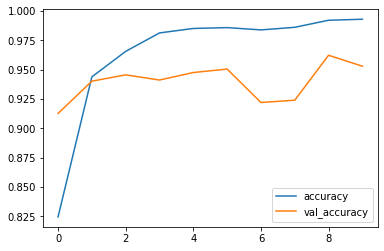

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
# history_df

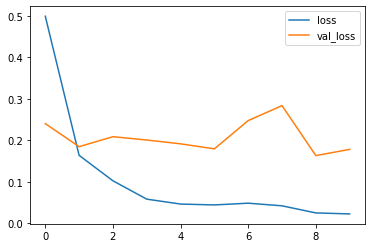

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [18]:
Y_pred = model.predict(x_val)

64/64 [==============================] - 9s 76ms/step


In [19]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

0.9528718703976435

### Classification Report

In [20]:
from sklearn.metrics import classification_report

print(classification_report( np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1), target_names=['benign', 'malignant', 'Normal']))

              precision    recall  f1-score   support

      benign       0.97      0.90      0.94       757
   malignant       0.94      0.99      0.96      1225
      Normal       0.93      0.93      0.93        55

    accuracy                           0.95      2037
   macro avg       0.95      0.94      0.94      2037
weighted avg       0.95      0.95      0.95      2037

